# 2.6. Introducing a deeper network

## Data loading and preprocessing

Data from https://www.kaggle.com/rajeevw/ufcdata?select=preprocessed_data.csv

In [ ]:
import pandas as pd
from google.colab import files
# uploaded = files.upload()
data = pd.read_csv('https://storage.googleapis.com/activation-function/csv/ufc.csv')
data = data.sample(frac=1)  # a bit weird
data.head()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,...,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Open Weight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
2152,Red,False,3,1.0,0.0,0.0,7.000,5.000,0.00,0.000,29.000,13.000000,0.000000,0.000,22.00,8.000000,0.0,0.000000,0.000000,0.0,0.00,29.000000,13.000000,0.44000,0.000000,0.000000,0.000000,0.000000,29.000000,13.000000,0.0,1.0,1.000000,1.000000,2.000,1.000000,24.000,7.000000,2.000000,2.000000,...,49.000000,29.000000,1.0,158.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.88,182.88,145.0,28.0,24.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
326,Blue,False,5,0.0,1.0,0.0,8.125,5.375,6.25,4.875,55.125,22.875000,3.500000,2.625,53.75,22.375000,0.5,3.000000,2.625000,0.5,0.25,64.875000,30.375000,0.47125,0.250000,1.375000,0.375000,0.091250,69.875000,34.875000,3.0,3.0,9.250000,6.750000,6.625,3.875000,48.875,22.125000,17.125000,13.500000,...,109.529412,61.352941,44.0,688.058824,3.0,0.0,1.0,1.0,7.0,0.0,0.0,9.0,185.42,193.04,205.0,29.0,36.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1543,Red,False,3,1.0,0.0,0.0,7.000,3.000,9.00,6.000,22.000,7.000000,0.000000,0.000,23.00,9.000000,0.0,1.000000,1.000000,1.0,0.00,31.000000,13.000000,0.41000,0.000000,4.000000,2.000000,0.500000,37.000000,18.000000,0.0,1.0,15.000000,10.000000,13.000,11.000000,38.000,21.000000,52.000000,41.000000,...,180.000000,121.000000,3.0,900.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.88,185.42,170.0,30.0,26.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1500,Red,False,3,2.0,0.0,0.0,19.400,10.400,7.40,5.600,144.200,47.200000,3.200000,2.200,124.80,38.600000,0.4,10.600000,6.000000,0.4,0.00,154.800000,55.000000,0.34200,0.400000,1.000000,0.400000,0.300000,158.000000,58.200000,3.0,2.0,8.800000,5.600000,8.400,5.000000,108.800,41.400000,4.000000,2.000000,...,65.142857,39.142857,27.0,495.071429,0.0,0.0,1.0,3.0,4.0,0.0,0.0,8.0,182.88,182.88,185.0,27.0,37.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3087,Red,False,3,0.0,1.0,0.0,3.000,2.500,10.00,8.000,11.000,2.333333,8.333333,6.000,17.00,5.666667,0.0,9.333333,8.166667,1.0,0.50,29.333333,16.333333,0.58500,0.833333,5.833333,0.833333,0.178333,56.333333,41.833333,2.0,2.0,3.333333,2.833333,10.500,7.333333,12.500,4.833333,16.666667,9.166667,...,34.500000,25.000000,3.0,303.500000,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,185.42,182.88,170.0,33.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
data['Winner'] = data['Winner'].map(lambda x: 1 if x == 'Red' else 0)
data['title_bout'] = data['title_bout'].map(lambda x: 1 if x == 'True' else 0)

In [ ]:
train_size = int(0.8*len(data))
features = data.drop(columns=['Winner'])
targets = data['Winner']
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.pairplot(data)

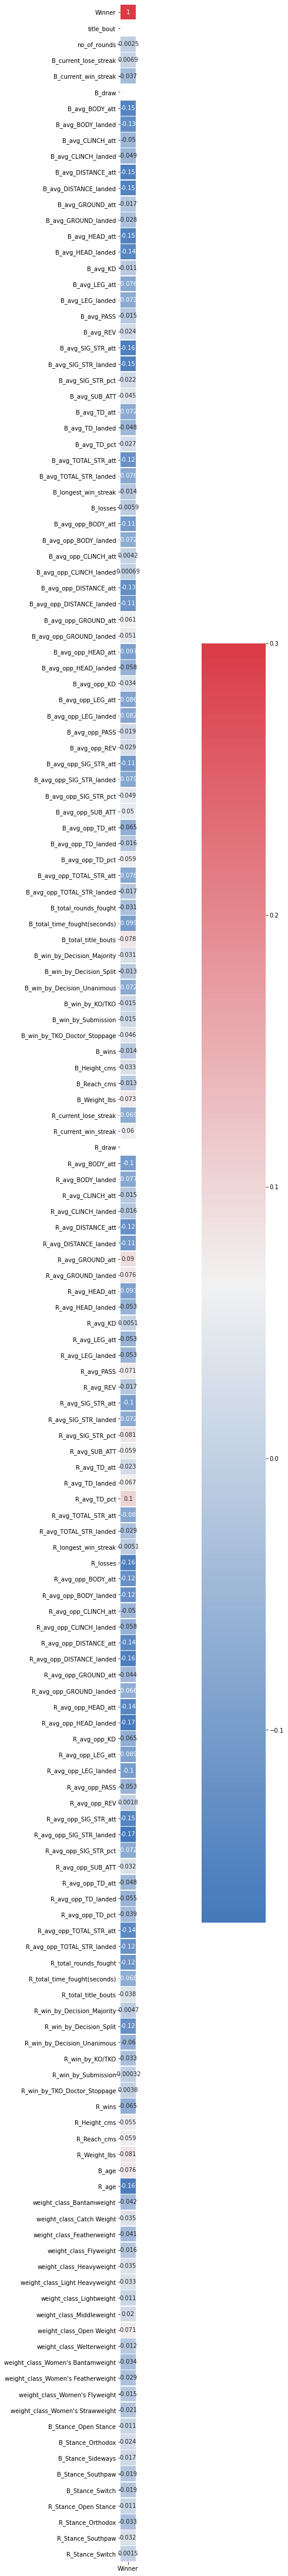

In [ ]:
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(40, 80))
sns.heatmap(corr[['Winner']], cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

## TensorFlow ANNs

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), # x if x > 0 else alpha*x 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # [0, 1]
])

red = len(y_train[y_train>0])
blue = len(y_train) - red
total = len(y_train)
weight_for_red = total / (2 * red) 
weight_for_blue = total / (2 * blue)
class_weight = {0: weight_for_blue, 1: weight_for_red}
print(class_weight)

adam_optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/model-{epoch:02d}-{val_accuracy:.2f}.hdf5', 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False,
    save_frequency=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled, 
          y_train,
          class_weight=class_weight,
          batch_size=64,
          validation_split=0.1,
          #callbacks=[save_best_callback],
          epochs=20)

{0: 1.510515247108307, 1: 0.7473985431841832}
Epoch 1/20
41/41 [==============================] - 4s 47ms/step - loss: 0.7638 - tp: 551.4048 - fp: 196.9524 - tn: 255.9286 - fn: 368.3333 - accuracy: 0.5764 - precision: 0.7260 - recall: 0.5947 - auc: 0.5825 - val_loss: 0.6579 - val_tp: 110.0000 - val_fp: 34.0000 - val_tn: 69.0000 - val_fn: 75.0000 - val_accuracy: 0.6215 - val_precision: 0.7639 - val_recall: 0.5946 - val_auc: 0.6745
Epoch 2/20
41/41 [==============================] - 1s 17ms/step - loss: 0.6659 - tp: 545.7143 - fp: 147.8333 - tn: 311.0714 - fn: 368.0000 - accuracy: 0.6190 - precision: 0.7881 - recall: 0.5778 - auc: 0.6919 - val_loss: 0.6129 - val_tp: 124.0000 - val_fp: 37.0000 - val_tn: 66.0000 - val_fn: 61.0000 - val_accuracy: 0.6597 - val_precision: 0.7702 - val_recall: 0.6703 - val_auc: 0.6992
Epoch 3/20
41/41 [==============================] - 1s 17ms/step - loss: 0.6220 - tp: 581.8095 - fp: 138.7381 - tn: 314.5714 - fn: 337.5000 - accuracy: 0.6564 - precision: 0.8108

In [ ]:
import numpy as np
#model = tf.keras.models.load_model('/content/model-43-0.64.hdf5')
X_test_scaled = scaler.transform(X_test)
model.evaluate(X_test_scaled, y_test)

23/23 [==============================] - 0s 4ms/step - loss: 0.7359 - tp: 287.0000 - fp: 110.0000 - tn: 151.0000 - fn: 171.0000 - accuracy: 0.6092 - precision: 0.7229 - recall: 0.6266 - auc: 0.6425


[0.7359281182289124,
 287.0,
 110.0,
 151.0,
 171.0,
 0.6091794371604919,
 0.7229219079017639,
 0.6266375780105591,
 0.6425195336341858]

In [ ]:
np.round(model.predict(X_test))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],